# Information Bottleneck theory for Deep Learning

This is a demonstration of the information bottleneck theory for deep learning, introduced by Naftali Tishby. Here I tried to reproduce the main results in their recent paper [Opening the black box of Deep Neural Networks via Information](https://arxiv.org/pdf/1703.00810.pdf).

## Data generation

First, we will generate a very simple dataset for the demonstration. The inputs are vectors of 10 binaries, and the outputs are just single binaries. The inputs could be represented by integers from 0 to 1023 ($=2^{10}-1$). The 1024 possible inputs are divided into 16 groups (each group has 64 numbers), and each integer input $n\in[0,1023]$ belongs to group $i$ if $x\equiv i \pmod{16}$, where $i \in [0,15]$. Each group $i$ is then associated with a random binary number - we build kinda of a distribution over space of possible discrete states (output).

In [2]:
%pylab inline

import torch
import torch.optim as optim
import torch.nn as nn

import numpy as np
from random import randint, seed

# Flag to enable execution on GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Populating the interactive namespace from numpy and matplotlib


In [3]:
n_train_samples = 50000 # number of train samples
n_test_samples = 10000 # number of test samples

groups = np.append(np.zeros(8),np.ones(8)) # 16 groups
print(groups)
np.random.seed(1234)
torch.manual_seed(1234)
np.random.shuffle(groups)

# generate samples
seed(1234)
def generate_samples(n_samples):
    x_data = np.zeros((n_samples, 10)) # inputs
    x_int = np.zeros(n_samples) # integers representing the inputs
    y_data = np.zeros((n_samples, 2)) # outputs
    
    for i in range(n_samples):
        random_int = randint(0, 1023)
        x_data[i,:] = [int(b) for b in list("{0:b}".format(random_int).zfill(10))]
        x_int[i] = random_int
        y_data[i,0] = groups[random_int % 16]
        y_data[i,1] = 1 - y_data[i,0]
        
    return x_data, y_data, x_int

x_train, y_train, x_train_int = generate_samples(n_train_samples) # training dataset
x_test, y_test, _ = generate_samples(n_test_samples) # testing dataset

[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
d={}
for i in y_train:
    d[str(i[0])+', '+str(i[1])] = 0
for i in y_train:
    d[str(i[0])+', '+str(i[1])] += 1
print('Distribution of classes: ', d)

Distribution of classes:  {'1.0, 0.0': 24820, '0.0, 1.0': 25180}


For our dataset, the theoritical mutual information between $X$ and $Y$ would be
\begin{align}
I(X;Y) & = \sum_{x\in X, y\in Y}P(x,y)\log\Big(\frac{P(x,y)}{P(x)P(y)}\Big) \\
& = \sum_{x\in X}\Big[P(x,y=0)\log\Big(\frac{P(x,y=0)}{P(x)P(y=0)}\Big) + P(x,y=1)\log\Big(\frac{P(x,y=1)}{P(x)P(y=1)}\Big)\Big] \\
& = 1024 \Big[ \frac{1}{1024}\log\Big(\frac{1/1024}{0.5/1024}\Big) + 0\Big] \\
& = 0.693.
\end{align}
Note that terms with $P(x,y)=0$ are set to $0$ for entropy calculation.

In [0]:
class MLP(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_classes, neg_slope=0.02):
        super(MLP, self).__init__()
        self.n_inputs = n_inputs,
        self.n_hidden = n_hidden,
        self.n_classes = n_classes
        
        self.layers = []
        self.num_neurons = [n_inputs] + n_hidden + [n_classes]
        self.models = {}
        for i in range(len(self.num_neurons) - 2):
            self.layers.append(nn.Linear(self.num_neurons[i], self.num_neurons[i+1]))
            self.layers.append(nn.Tanh())
            self.models['Linear{}'.format(i)] = nn.Sequential(*self.layers)
            

        self.layers.append(nn.Linear(self.num_neurons[i+1], self.num_neurons[i+2]))
        self.models['Output'] = nn.Sequential(*self.layers)
        self.full_model = self.models['Output']
        
        
        
    def forward(self, x, exitLayer=None): 
        if exitLayer is not None:
            out = self.models[exitLayer](x)
        else:
            out = self.full_model(x)
        return out

class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()
        
        self.z_dim = z_dim
        
        # Vanilla MLP
        self.net = nn.Sequential(
            nn.Linear(10, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, z_dim*2),
        )
        
    def forward(self, x):
        x = x.view(x.size(0),-1) # Flatten the input
        params = self.net(x)
        
        mu, sigma = params[:,:self.z_dim], params[:,self.z_dim:]
        sigma = softplus(sigma) + 1e-7  # Make sigma always positive
        
        return Independent(Normal(loc=mu, scale=sigma), 1) # Return a factorized Normal distribution

In [0]:
def get_named_layers(net):
    conv2d_idx = 0
    convT2d_idx = 0
    linear_idx = 0
    batchnorm2d_idx = 0
    named_layers = {}
    for mod in net.modules():
        if isinstance(mod, torch.nn.Conv2d):
            layer_name = 'Conv2d{}_{}-{}'.format(
                conv2d_idx, mod.in_channels, mod.out_channels
            )
            named_layers[layer_name] = mod
            conv2d_idx += 1
        elif isinstance(mod, torch.nn.ConvTranspose2d):
            layer_name = 'ConvT2d{}_{}-{}'.format(
                conv2d_idx, mod.in_channels, mod.out_channels
            )
            named_layers[layer_name] = mod
            convT2d_idx += 1
        elif isinstance(mod, torch.nn.BatchNorm2d):
            layer_name = 'BatchNorm2D{}_{}'.format(
                batchnorm2d_idx, mod.num_features)
            named_layers[layer_name] = mod
            batchnorm2d_idx += 1
        elif isinstance(mod, torch.nn.Linear):
            layer_name = 'Linear{}_{}-{}'.format(
                linear_idx, mod.in_features, mod.out_features
            )
            named_layers[layer_name] = mod
            linear_idx += 1
    return named_layers

def accuracy(predictions, targets):
    accuracy = (predictions.argmax(dim=1) == targets.argmax(dim=1)).type(torch.FloatTensor).mean().item()
    return accuracy

In [7]:
num_epochs = 2000
dnn_hidden_units = [16, 12, 8, 6, 4]
dnn_input_units = x_train.shape[1]
dnn_output_units = y_train.shape[1]
eval_freq = 100

MLP_object = MLP(dnn_input_units, dnn_hidden_units, dnn_output_units).to(device)
get_named_layers(MLP_object)
#MLP_object.parameters()
print(MLP_object.models)

{'Linear0': Sequential(
  (0): Linear(in_features=10, out_features=16, bias=True)
  (1): Tanh()
), 'Linear1': Sequential(
  (0): Linear(in_features=10, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=12, bias=True)
  (3): Tanh()
), 'Linear2': Sequential(
  (0): Linear(in_features=10, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=12, bias=True)
  (3): Tanh()
  (4): Linear(in_features=12, out_features=8, bias=True)
  (5): Tanh()
), 'Linear3': Sequential(
  (0): Linear(in_features=10, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=12, bias=True)
  (3): Tanh()
  (4): Linear(in_features=12, out_features=8, bias=True)
  (5): Tanh()
  (6): Linear(in_features=8, out_features=6, bias=True)
  (7): Tanh()
), 'Linear4': Sequential(
  (0): Linear(in_features=10, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=12, bias=True)
  (3): Tanh()
  (4): Linea

In [0]:
from collections import Counter

#Calculate real MI throughout training
def calc_mutual_information(hidden):
    n_neurons = hidden.shape[-1]
  
    # discretization 
    n_bins = 30
    bins = np.linspace(-1, 1, n_bins+1)
    indices = np.digitize(hidden, bins)
    
    # initialize pdfs
    pdf_x = Counter(); pdf_y = Counter(); pdf_t = Counter(); pdf_xt = Counter(); pdf_yt = Counter()

    for i in range(n_train_samples):
        pdf_x[x_train_int[i]] += 1/float(n_train_samples)
        pdf_y[y_train[i,0]] += 1/float(n_train_samples)      
        pdf_xt[(x_train_int[i],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_yt[(y_train[i,0],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_t[tuple(indices[i,:])] += 1/float(n_train_samples)
    
    # calcuate encoder mutual information I(X;T)
    mi_xt = 0
    for i in pdf_xt:
        # P(x,t), P(x) and P(t)
        p_xt = pdf_xt[i]; p_x = pdf_x[i[0]]; p_t = pdf_t[i[1:]]
        # I(X;T)
        mi_xt += p_xt * np.log(p_xt / p_x / p_t)
 
    # calculate decoder mutual information I(T;Y)
    mi_ty = 0
    for i in pdf_yt:
        # P(t,y), P(t) and P(y)
        p_yt = pdf_yt[i]; p_t = pdf_t[i[1:]]; p_y = pdf_y[i[0]]
        # I(T;Y)
        try:
          mi_ty += p_yt * np.log(p_yt / p_t / p_y)
        except ZeroDivisionError:
          mi_ty += p_yt * np.log(p_yt / (p_t + 1e-5) / (p_y + 1e-5))
            
    return mi_xt, mi_ty

# get mutual information for all hidden layers
def get_mutual_information(hidden):
    mi_xt_list = []; mi_ty_list = []
    # for hidden in hiddens:
    if True:
        mi_xt, mi_ty = calc_mutual_information(hidden)
        mi_xt_list.append(mi_xt)
        mi_ty_list.append(mi_ty)
    return mi_xt_list, mi_ty_list

In [9]:
def train_encoder(enc_type='MLP', layer='Linear4'):
  
    if enc_type == 'MLP':
      Net = MLP(dnn_input_units, dnn_hidden_units, dnn_output_units).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(Net.parameters(), lr=3e-3)#, momentum=0.2)
    
    X_test, Y_test = torch.tensor(x_test, requires_grad=False).float().to(device), torch.tensor(y_test, requires_grad=False).float().to(device)
    accuracy_evaluation = {'train': [], 'test': []}
    loss_evaluation = {'train': [], 'test': []}
    mi_xt_all = []; mi_ty_all = []; epochs = []
    start_time = time.time()
    for epoch in range(num_epochs):
        X_train, Y_train = torch.from_numpy(x_train).float().to(device), torch.from_numpy(y_train).float().to(device)
        
        optimizer.zero_grad()
        
        out = Net(X_train)
        loss = criterion(out, Y_train.argmax(dim=1))
        loss.backward()
        optimizer.step()

        if epoch % eval_freq == 0 or epoch == num_epochs - 1:
            mi_xt, mi_ty = get_mutual_information(Net.models['Linear4'](X_train).cpu().data.numpy())
            mi_xt_all.append(mi_xt)
            mi_ty_all.append(mi_ty)
            print('#'*30)
            print('Step - ', epoch)
            print('Train: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(out, Y_train), loss))
            print('Test: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(Net(X_test), Y_test), criterion(Net(X_test), Y_test.argmax(dim=1))))
            print('I(X, T) - ', mi_xt)
            print('I(T, Y) - ', mi_ty)
            print('Elapse time: ', time.time() - start_time)
            print('#'*30,'\n')

    return Net, mi_xt, mi_ty
Encoder, true_MI_x, true_MI_y = train_encoder(layer = 'Linear3')
print(Encoder)

##############################
Step -  0
Train: Accuracy - 0.496, Loss - 0.703
Test: Accuracy - 0.496, Loss - 0.701
I(X, T) -  [1.7959401525079728]
I(T, Y) -  [0.008007460799442659]
Elapse time:  0.44308924674987793
############################## 

##############################
Step -  100
Train: Accuracy - 0.750, Loss - 0.485
Test: Accuracy - 0.751, Loss - 0.483
I(X, T) -  [1.9846161172971344]
I(T, Y) -  [0.3495621499711857]
Elapse time:  1.3837628364562988
############################## 

##############################
Step -  200
Train: Accuracy - 0.873, Loss - 0.211
Test: Accuracy - 0.874, Loss - 0.206
I(X, T) -  [2.1511290522561697]
I(T, Y) -  [0.6931212603355825]
Elapse time:  2.3136985301971436
############################## 

##############################
Step -  300
Train: Accuracy - 1.000, Loss - 0.013
Test: Accuracy - 1.000, Loss - 0.013
I(X, T) -  [2.0620822028026318]
I(T, Y) -  [0.693121260335538]
Elapse time:  3.1441450119018555
############################## 

########

In [0]:
from torch.nn.functional import softplus

# Neural approximation of MI starts here
# Auxiliary network for mutual information estimation
class MIEstimator(nn.Module):
    def __init__(self, size1, size2):
        super(MIEstimator, self).__init__()
        
        # Vanilla MLP
        self.net = nn.Sequential(
            nn.Linear(size1 + size2, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1),
        )
    
    # Gradient for JSD mutual information estimation and EB-based estimation
    def forward(self, x1, x2):
        # breakpoint()
        pos = self.net(torch.cat([x1, x2], 1)) #Positive Samples 
        neg = self.net(torch.cat([torch.roll(x1, 1, 0), x2], 1)) #Predictions for shuffled (negative) samples from p(z1)p(z2)
        #breakpoint()
        return -softplus(-pos).mean() - softplus(neg).mean(), pos.mean() - neg.exp().mean() + 1

We are now able to estimate the mutual information while training the network. We'll save the mutual information for later use.

In [0]:
from torch.utils.data import Subset
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

class Scheduler:
    def __call__(self, **kwargs):
        raise NotImplemented()

class LinearScheduler(Scheduler):
    def __init__(self, start_value, end_value, n_iterations, start_iteration=0):
        self.start_value = start_value
        self.end_value = end_value
        self.n_iterations = n_iterations
        self.start_iteration = start_iteration
        self.m = (end_value - start_value) / n_iterations

    def __call__(self, iteration):
        if iteration > self.start_iteration + self.n_iterations:
            return self.end_value
        elif iteration <= self.start_iteration:
            return self.start_value
        else:
            return (iteration - self.start_iteration) * self.m + self.start_value

class ExponentialScheduler(LinearScheduler):
    def __init__(self, start_value, end_value, n_iterations, start_iteration=0, base=10):
        self.base = base

        super(ExponentialScheduler, self).__init__(start_value=math.log(start_value, base),
                                                   end_value=math.log(end_value, base),
                                                   n_iterations=n_iterations,
                                                   start_iteration=start_iteration)

    def __call__(self, iteration):
        linear_value = super(ExponentialScheduler, self).__call__(iteration)
        return self.base ** linear_value

def split(dataset, size, split_type):
    if split_type == 'Random':
        data_split, _ = torch.utils.data.random_split(dataset, [size, len(dataset) - size])
    elif split_type == 'Balanced':
        class_ids = {}
        for idx, (_, y) in enumerate(dataset):
            try:
                y = int(y.item())
            except:
                pass
            if y not in class_ids:
                class_ids[y] = []
            class_ids[y].append(idx)

        ids_per_class = size // len(class_ids)

        selected_ids = []

        for ids in class_ids.values():
            selected_ids += list(np.random.choice(ids, min(ids_per_class, len(ids)), replace=False))
        data_split = torch.utils.data.Subset(dataset, selected_ids)

    return data_split


class EmbeddedDataset:
    BLOCK_SIZE = 1

    def __init__(self, base_dataset, encoder, cuda=True):
        if cuda:
            encoder = encoder.cuda()
        self.means, self.target = self._embed(encoder, base_dataset, cuda)

    def _embed(self, encoder, dataset, cuda):
        encoder.eval()

        data_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=self.BLOCK_SIZE,
            shuffle=False)

        ys = []
        reps = []
        with torch.no_grad():
            for x, y in data_loader:
                if cuda:
                    x = x.cuda()
                    y = y.cuda()

                p_z_given_x = encoder(x)
                reps.append(p_z_given_x.detach())
                ys.append(y)

            ys = torch.cat(ys, 0)

        encoder.train()
        return reps, ys

    def __getitem__(self, index):
        y = self.target[index]
        x = self.means[index][0]# // self.BLOCK_SIZE][index % self.BLOCK_SIZE]
        return x, y

    def __len__(self):
        return self.target.size(0)

def train_and_evaluate_linear_model(train_set, test_set, solver='saga', multi_class='multinomial', tol=.1, C=2):
    model = LogisticRegression(solver=solver, multi_class=multi_class, tol=tol, C=C)
    scaler = MinMaxScaler()

    x_train, y_train = build_matrix(train_set)
    x_test, y_test = build_matrix(test_set)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    model.fit(x_train, y_train)
    test_accuracy = model.score(x_test, y_test)
    train_accuracy = model.score(x_train, y_train)

    return train_accuracy, test_accuracy


def build_matrix(dataset):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False)

    xs = []
    ys = []

    for x, y in data_loader:
        xs.append(x)
        ys.append(y)

    xs = torch.cat(xs, 0)
    ys = torch.cat(ys, 0)

    if xs.is_cuda:
        xs = xs.cpu()
    if ys.is_cuda:
        ys = ys.cpu()

    return xs.data.numpy(), ys.data.numpy()

def evaluate(encoder, train_on, test_on, cuda):
    embedded_train = EmbeddedDataset(train_on, encoder, cuda=cuda)
    embedded_test = EmbeddedDataset(test_on, encoder, cuda=cuda)
    return train_and_evaluate_linear_model(embedded_train, embedded_test)

In [0]:
def train_MI(encoder, num_epochs=2000, dnn_hidden_units=[]):
    
    #x_train, y_train, x_train_int = generate_samples(n_train_samples) # training dataset
    #x_test, y_test, _ = generate_samples(n_test_samples) # testing dataset
    mi_xt_all = []; mi_ty_all = []; epochs = []
    mi_xz = []; mi_zy = []

    X_test, Y_test = torch.tensor(x_test, requires_grad=False).to(device), torch.tensor(y_test, requires_grad=False).to(device)

    z_test = torch.tensor(encoder(X_test.float()), requires_grad=False).to(device)

    x_dim, y_dim, z_dim = x_test.shape[-1], y_test.shape[-1], z_test.shape[-1]
    print(x_dim, y_dim, z_dim)
    mi_estimator_X = MIEstimator(x_dim, z_dim).to(device)
    mi_estimator_Y = MIEstimator(z_dim, y_dim).to(device)

    optimizer = optim.Adam([
    {'params': mi_estimator_X.parameters(), 'lr':1e-3},
    {'params': mi_estimator_Y.parameters(), 'lr':1e-3},
    ])

    beta_scheduler = ExponentialScheduler(start_value=1e-9, end_value=1e-2, n_iterations=num_epochs, start_iteration=10)

    accuracy_evaluation = {'train': [], 'test': []}
    loss_evaluation = {'train': [], 'test': []}

    start_time = time.time()
    max_MI_x, max_MI_y = 0, 0
    mi_est_all = {'X': [], 'Y': []}
    for epoch in range(num_epochs):
        beta = beta_scheduler(epoch)

        X_train, Y_train = torch.from_numpy(x_train).to(device).float(), torch.from_numpy(y_train).to(device).float()
        z_train = encoder(X_train.float())

        optimizer.zero_grad()
        mi_gradient_X, mi_estimation_X = mi_estimator_X(X_train, z_train)
        mi_gradient_X = mi_gradient_X.mean()
        mi_estimation_X = mi_estimation_X.mean()

        mi_gradient_Y, mi_estimation_Y = mi_estimator_Y(z_train, Y_train.float())
        mi_gradient_Y = mi_gradient_Y.mean()
        mi_estimation_Y = mi_estimation_Y.mean()
                
        loss_mi = - mi_gradient_Y - mi_gradient_X
        loss_mi.backward()
        optimizer.step()
        mi_est_all['X'].append(mi_estimation_X.cpu().data.numpy())
        mi_est_all['Y'].append(mi_estimation_Y.cpu().data.numpy())
        eval_freq = 10
        if epoch >= 500:
          if mi_estimation_X > max_MI_x:
            max_MI_x = mi_estimation_X.cpu().data.numpy()
          if np.mean(mi_est_all['X'][-100]) > max_MI_x - 1e-1:
            break
        if epoch % eval_freq == 0 or epoch == num_epochs - 1:
            mi_xt, mi_ty = get_mutual_information(z_train.cpu().data.numpy())
            mi_xt_all.append(mi_xt)
            mi_ty_all.append(mi_ty)
            print('#'*30)
            print('Step - ', epoch)
            # print('Train: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(out, Y_train), loss))
            # print('Test: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(predictor(z_test.float()), Y_test), criterion(predictor(z_test.float()), Y_test.argmax(dim=1))))
            print('I(X, T) - ', mi_xt)
            print('I(T, Y) - ', mi_ty)
            print('I_est(X, T)', mi_estimation_X)
            #print('Grad I_est(X, T)', mi_gradient_X)
            print('I_est(T, Y)', mi_estimation_Y)
            #print('Grad I_est(T, Y)', mi_gradient_Y)
            print('Time after last eval: ', time.time() - start_time)
            print('#'*30,'\n')
            
    return max_MI_x, max_MI_y

n_train_samples = 50000
n_test_samples = 10000


num_labels_range = [2**i for i in range(1, int(np.log2(n_train_samples)-8))]

acc = {i:[] for i in num_labels_range}
print(num_labels_range)
seeds = [9, 42, 103, 48, 79]
layers = ['Linear2', 'Linear 3', 'Linear4']
mi_layers = {}
for seed_ in seeds:

    
    print('\nRunning with seed ', seed_)
    torch.manual_seed(seed_)
    np.random.seed(seed_)
    seed(seed_)
    
    
    for layer in layers:

        x_train, y_train, x_train_int = generate_samples(n_train_samples) # training dataset
        x_test, y_test, _ = generate_samples(10*n_test_samples) # testing dataset
        if seed_ == 9:
            MI_X, MI_Y = train_MI(Encoder.models[layer], num_epochs=2000)
            mi_layers[layer] = (MI_X, MI_Y)
        y_train = y_train.argmax(axis=1)
        y_test = y_test.argmax(axis=1)
        train_set = torch.utils.data.TensorDataset(torch.Tensor(x_train).to(device), torch.Tensor(y_train).to(device)) 
        test_set = torch.utils.data.TensorDataset(torch.Tensor(x_test).to(device), torch.Tensor(y_test).to(device))
    
        print('MI values for %s - %s, %s' % (layer, MI_X, MI_Y))
        for num_labels in num_labels_range:
            print('Evaluating for %s %s' % (layer, num_labels))
            #acc[layer].append(train_MI(num_labels, Encoder, num_epochs=2000))
            


            train_subset = split(train_set, num_labels, 'Balanced') 
            test_subset = split(train_set, n_test_samples, 'Random') 
            train_accuracy, test_accuracy = evaluate(encoder=Encoder.models[layer], train_on=train_subset, test_on=test_subset, cuda=torch.cuda.is_available())
            #train_accuracy, test_accuracy = train_and_evaluate_linear_model(train_subset, test_set, C=2)
            print('Train Accuracy: %f'% train_accuracy)
            print('Test Accuracy: %f'% test_accuracy)
            acc[num_labels].append(test_accuracy)

[2, 4, 8, 16, 32, 64]

Running with seed  9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


10 2 8
##############################
Step -  0
I(X, T) -  [3.48226004319869]
I(T, Y) -  [0.6931421877511955]
I_est(X, T) tensor(-0.0203, device='cuda:0', grad_fn=<MeanBackward0>)
I_est(T, Y) tensor(-0.0058, device='cuda:0', grad_fn=<MeanBackward0>)
Time after last eval:  0.6959233283996582
############################## 

##############################
Step -  10
I(X, T) -  [3.48226004319869]
I(T, Y) -  [0.6931421877511955]
I_est(X, T) tensor(0.1403, device='cuda:0', grad_fn=<MeanBackward0>)
I_est(T, Y) tensor(0.4235, device='cuda:0', grad_fn=<MeanBackward0>)
Time after last eval:  3.1214561462402344
############################## 

##############################
Step -  20
I(X, T) -  [3.48226004319869]
I(T, Y) -  [0.6931421877511955]
I_est(X, T) tensor(0.4866, device='cuda:0', grad_fn=<MeanBackward0>)
I_est(T, Y) tensor(0.6703, device='cuda:0', grad_fn=<MeanBackward0>)
Time after last eval:  5.543750762939453
############################## 

##############################
Step -  30


Text(0, 0.5, 'Accuracy')

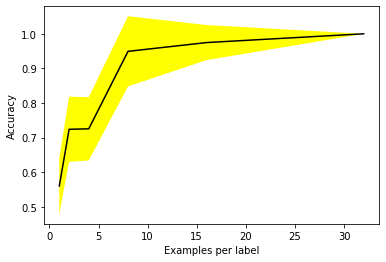

In [28]:
values = []
for key in acc.keys():
    values.append((np.mean(acc[key]), np.std(acc[key])))
means = np.array([i[0] for i in values])
stds = np.array([i[1] for i in values])
fig, ax = plt.subplots(1, 1, sharex=True)
nums = np.array(num_labels_range)
ax.plot(nums/2, means, color='black', label='Linear-2')
ax.fill_between(nums/2, means - stds, means + stds, facecolor='yellow', interpolate=True)
ax.set_xlabel('Examples per label')
ax.set_ylabel('Accuracy')